# EQUIVALENCE CLASS:
A stimulus class (usually produced through conditional discrimination in matching-to-sample) that includes all possible emergent relations among its members. The properties of an equivalence class are derived from the logical relations of reflexivity, symmetry, and transitivity. **Reflexivity** *refers to the matching of a sample to itself*, sometimes called identity matching (AA, BB, CC, in these examples, each letter pair represents a sample and its matching comparison stimulus). **Symmetry** *refers to the reversibility of a relation (if AB, then BA)*. **Transitivity** *refers to the transfer of the relation to new combinations through shared membership (if AB and BC, then AC)*. 
If these properties are characteristics of a matching to-sample performance, then training AB and BC may produce AC, BA, CA, and CB as emergent relations (reflexivity provides the three other possible relations, AA, BB, and CC). Given AB and BC, for example, the combination of symmetry and transitivity implies the CA relation. The emergence of all possible stimulus relations after only AB and BC are trained through contingencies is the criterion for calling the three stimuli members of an equivalence class. The class can be extended by training new stimulus relations (e.g., if CD is learned, then AD, DA, BD, DB, and DC may be created as emergent relations). Stimuli that are members of an equivalence class are likely also to be functionally equivalent. It remains to be seen whether the logical properties of these classes are fully consistent with their behavioral ones. Cf. **EQUIVALENCE RELATION**. ([source](http://www.scienceofbehavior.com/lms/mod/glossary/view.php?id=408&mode=letter&hook=E&sortkey=CREATION&sortorder=asc&fullsearch=0&page=3))


# Libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from time import localtime, strftime

%matplotlib inline
plt.style.use('seaborn')

### Clasifiers dependences
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score

In [2]:
print("Python", sys.version)

Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]


In [3]:
!conda info


     active environment : sociadisticas
    active env location : C:\Users\Usuario\.conda\envs\sociadisticas
            shell level : 2
       user config file : C:\Users\Usuario\.condarc
 populated config files : C:\Users\Usuario\.condarc
          conda version : 4.8.3
    conda-build version : 3.18.11
         python version : 3.7.7.final.0
       virtual packages : 
       base environment : C:\ProgramData\Anaconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/noarch
          package cache : C:\ProgramData\Anaconda3\pkgs
                          C:\Users\Usuario\.conda\pkgs
                          C:\Users\Usuari

In [4]:
def get_trials_subset(trials_info_df, trial_subset_name, array_embeddings_trials, array_answers_trials):
    # No-go Trials can not be filtered with this...
    element = array_embeddings_trials[:,0]
    test_elements = list(trials_info_df.index[((trials_info_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]==trial_subset_name).sum(axis=1)>0)])
    mask = np.isin(element, test_elements)
    values_subset= array_embeddings_trials[mask][:,1:]
    answers_subset=array_answers_trials[mask][:,1:]
    info_subset=trials_info_df.loc[test_elements,:]
    return values_subset,answers_subset,info_subset

def view_trial(trials_info_df,trial_values,trial_ans, n_trial, n_stimuli=4, n_modes=3, n_classes=5):
    print (trials_info_df.iloc[n_trial,:])
    print (np.array(trial_values[n_trial]).reshape((n_stimuli,n_modes,n_classes)))
    print (trial_ans[n_trial])

In [5]:
stims={"A1":[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
       "A2":[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
       "A3":[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
       "A4":[0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
       "TX":[0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],# For explicitly train class emergency
       "B1":[0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
       "B2":[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
       "B3":[0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
       "B4":[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
       "TY":[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],# For explicitly train class emergency
       "C1":[0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
       "C2":[0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
       "C3":[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
       "C4":[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
       "TZ":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]# For explicitly train class emergency
      }

options={"O_1":[1,0,0],
         "O_2":[0,1,0],
         "O_3":[0,0,1],
         "O_0":[0,0,0],
        }

# Stimuli subsets

## Trainning 
### Relation $A_{n}-B_{n}$ and $B_{n}-C_{n}$

In [6]:
train_pairs=np.array([["A1","B1"],["B1","C1"],
                      ["A2","B2"],["B2","C2"],
                      ["A3","B3"],["B3","C3"],
                      ["A4","B4"],["B4","C4"],
                      ["A5","B5"],["B5","C5"],
                      ["A6","B6"],["B6","C6"]
                     ])
explicit_train_pairs=np.array([["TX","TY"],["TY","TZ"], # Pairs for Explicit Training
                               ["TX","TZ"], # Transitivity trainning
                               ["TZ","TX"], # Equivalence  trainning
                               ["TX","TX"],["TY","TY"],["TZ","TZ"], # Reflexivity trainning
                               ["TY","TX"],["TZ","TY"]# Symmetry trainning
                              ])

## Reflexivity evaluation

### Given the sample stimulus $A_{n}$ the agent must select $A_{n}$ among the comparator stimuli

In [7]:
reflexiv_pairs=np.array([[stm,stm]for stm in [let+str(num) for let in ["A","B","C"] for num in range(1,7)]])
reflexiv_pairs

array([['A1', 'A1'],
       ['A2', 'A2'],
       ['A3', 'A3'],
       ['A4', 'A4'],
       ['A5', 'A5'],
       ['A6', 'A6'],
       ['B1', 'B1'],
       ['B2', 'B2'],
       ['B3', 'B3'],
       ['B4', 'B4'],
       ['B5', 'B5'],
       ['B6', 'B6'],
       ['C1', 'C1'],
       ['C2', 'C2'],
       ['C3', 'C3'],
       ['C4', 'C4'],
       ['C5', 'C5'],
       ['C6', 'C6']], dtype='<U2')

## Symmetry evaluation
### Given the trainning pairs, the agent must select the comparator $A_{n}$ in presence of the sample $B_{n}$  and the comparator $B_{n}$ in presence of the sample $C_{n}$ 

In [8]:
symmetry_pairs=np.array([[tr_pr[1],tr_pr[0]]for tr_pr in train_pairs])
symmetry_pairs

array([['B1', 'A1'],
       ['C1', 'B1'],
       ['B2', 'A2'],
       ['C2', 'B2'],
       ['B3', 'A3'],
       ['C3', 'B3'],
       ['B4', 'A4'],
       ['C4', 'B4'],
       ['B5', 'A5'],
       ['C5', 'B5'],
       ['B6', 'A6'],
       ['C6', 'B6']], dtype='<U2')

## Transitivity
### Given the trainning pairs, the agent must select the comparator $C_{n}$ in presence of the sample $A_{n}$

In [9]:
transitivity_pairs=np.array([["A1","C1"],
                             ["A2","C2"],
                             ["A3","C3"],
                             ["A4","C4"],
                             ["A5","C5"],
                             ["A6","C6"]
                            ])

## Equivalence
### Given the trainning pairs, the agent must select the comparator $A_{n}$ in presence of the sample $C_{n}$

In [10]:
equivalence_pairs=np.array([[tr_pr[1],tr_pr[0]]for tr_pr in transitivity_pairs])

In [11]:
train_df=pd.DataFrame(train_pairs, columns=["st_sample", "st_comparator"])
train_df["pair_subset"]="train"

explicit_train_df=pd.DataFrame(explicit_train_pairs, columns=["st_sample", "st_comparator"])
explicit_train_df["pair_subset"]="explicit_train"

reflexivity_df=pd.DataFrame(reflexiv_pairs, columns=["st_sample", "st_comparator"])
reflexivity_df["pair_subset"]="reflexivity"

symmetry_df=pd.DataFrame(symmetry_pairs, columns=["st_sample", "st_comparator"])
symmetry_df["pair_subset"]="symmetry"

transitivity_df=pd.DataFrame(transitivity_pairs, columns=["st_sample", "st_comparator"])
transitivity_df["pair_subset"]="transitivity"

equivalence_df=pd.DataFrame(equivalence_pairs, columns=["st_sample", "st_comparator"])
equivalence_df["pair_subset"]="equivalence"

pairs_dataset=pd.concat([train_df,
                         explicit_train_df,
                         reflexivity_df,
                         symmetry_df,
                         transitivity_df,
                         equivalence_df], 
                        ignore_index=True, sort=False)

In [12]:
print(pairs_dataset.shape)
pairs_dataset

(63, 3)


,st_sample,st_comparator,pair_subset
0,A1,B1,train
1,B1,C1,train
2,A2,B2,train
3,B2,C2,train
4,A3,B3,train
...,...,...,...
58,C2,A2,equivalence
59,C3,A3,equivalence
60,C4,A4,equivalence
61,C5,A5,equivalence


In [13]:
pairs_dataset.pair_subset.value_counts()

reflexivity       18
symmetry          12
train             12
explicit_train     9
transitivity       6
equivalence        6
Name: pair_subset, dtype: int64

## Complete combination creation
Complete combination creation with 5 options and 7 classes costs time and memory. 21 stimuli combinations are $21^{6}=85766121$. Too much for a local machine.

Alternative  (until you find a better method): 
1. create loop for every combination. (for for for...)
2. evaluate each pair on trial. (train-eq-sym-tran-refl) inside the creation of the pair
3. Select trials with one pair identified. If pair not in subsets, then no-go pair (Marked as str_zero)

In [14]:
15**4

50625

In [15]:
test_combinations=np.array([[st_sample, st_comp1, st_comp2,st_comp3] 
                            for st_sample in list(stims.keys()) 
                            for st_comp1 in list(stims.keys())
                            for st_comp2 in list(stims.keys())
                            for st_comp3 in list(stims.keys())
])
test_combinations.shape

(50625, 4)

In [16]:
# break_loop=500
print("Start:::::::",strftime("%a, %d %b %Y %H:%M:%S", localtime()))
pair_info=[]
trial_comb=[]
trial_select=[]
trial_answer=[]
trial_values=[]
id_trial=0
for st_sample in list(stims.keys()):
    for st_comp1 in list(stims.keys()):
        for st_comp2 in list(stims.keys()):
            for st_comp3 in list(stims.keys()):
                trial=[id_trial,st_sample,
                       st_comp1,st_comp2,st_comp3]#,st_comp4,st_comp5
                trial_comb.append(trial)
                trial_pairs=[]
                for st_comparator_loop in [st_comp1,st_comp2,st_comp3]:#,st_comp4,st_comp5
                    search_pair=pairs_dataset.pair_subset[(pairs_dataset.st_sample==st_sample)&
                                                          (pairs_dataset.st_comparator==st_comparator_loop)]
                    trial_pairs.append(str(search_pair.sum()))
                    pair_info.append([id_trial,st_sample, st_comparator_loop, search_pair.sum()])# export line to file
                if (sum([pair_eval=="0" for pair_eval in trial_pairs])>1)&(len(list(set(trial_pairs)))<3):
                    option_filter=([not(pair_eval=="0") for pair_eval in trial_pairs])*1
                    option_key=list(options.keys())[list(options.values()).index(option_filter)]
                    trial_select.append([id_trial,st_sample,
                                         st_comp1,st_comp2,st_comp3,#st_comp4,st_comp5,
                                         trial_pairs[0],trial_pairs[1],trial_pairs[2],#,trial_pairs[3],trial_pairs[4]
                                         option_key
                                        ])
                    trial_embedding=[bit_emb for stml in [st_sample,st_comp1,st_comp2,st_comp3] for bit_emb in stims[stml]]
                    trial_embedding.insert(0,id_trial)
                    trial_values.append(trial_embedding)
                    option_embedding=options[option_key].copy()
                    option_embedding.insert(0,id_trial)
                    trial_answer.append(option_embedding)
                id_trial+=1
    print(st_sample, "processed", strftime("%a, %d %b %Y %H:%M:%S", localtime()))
#     if id_trial>break_loop:
#         print("break loop")
#         break


Start::::::: Mon, 25 May 2020 09:36:13
A1 processed Mon, 25 May 2020 09:36:24
A2 processed Mon, 25 May 2020 09:36:35
A3 processed Mon, 25 May 2020 09:36:46
A4 processed Mon, 25 May 2020 09:36:58
TX processed Mon, 25 May 2020 09:37:12
B1 processed Mon, 25 May 2020 09:37:24
B2 processed Mon, 25 May 2020 09:37:34
B3 processed Mon, 25 May 2020 09:37:44
B4 processed Mon, 25 May 2020 09:37:55
TY processed Mon, 25 May 2020 09:38:05
C1 processed Mon, 25 May 2020 09:38:16
C2 processed Mon, 25 May 2020 09:38:27
C3 processed Mon, 25 May 2020 09:38:37
C4 processed Mon, 25 May 2020 09:38:47
TZ processed Mon, 25 May 2020 09:38:58


In [17]:
pair_info_array=np.array(pair_info)
trial_comb_array=np.array(trial_comb)
trial_select_array=np.array(trial_select)
trial_answer_array=np.array(trial_answer)
trial_values_array=np.array(trial_values)

print("pair_info",pair_info_array.shape)
print("trial_comb",trial_comb_array.shape)
print("trial_select",trial_select_array.shape)
print("trial_answer",trial_answer_array.shape)
print("trial_values",trial_values_array.shape)

pair_info (151875, 4)
trial_comb (50625, 5)
trial_select (45360, 9)
trial_answer (45360, 4)
trial_values (45360, 61)


In [18]:
# pd.DataFrame(pair_info_array).to_csv("pair_info_array.csv")
# pd.DataFrame(trial_comb_array).to_csv("trial_comb_array.csv")
# pd.DataFrame(trial_select_array).to_csv("trial_select_array.csv")
# pd.DataFrame(trial_answer_array).to_csv("trial_answer_array.csv")
# pd.DataFrame(trial_values_array).to_csv("trial_values_array.csv")

In [19]:
dat_selected_df=pd.DataFrame(trial_select_array)
dat_selected_df.columns=["id_trial","st_sample",
                      "st_comp1","st_comp2","st_comp3",
                      "sample_c1_subset","sample_c2_subset","sample_c3_subset",
                      "option_answer"
                     ]
dat_selected_df.id_trial=pd.to_numeric(dat_selected_df.id_trial)
dat_selected_df.set_index("id_trial", inplace=True)

In [20]:
print("no-go trials ",((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="0").sum(axis=1)>2).sum())
print("train trials ",((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="train").sum(axis=1)>0).sum())
print("explicit_train trials ",((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="explicit_train").sum(axis=1)>0).sum())
print("reflexivity trials ",((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="reflexivity").sum(axis=1)>0).sum())
print("symmetry trials ",((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="symmetry").sum(axis=1)>0).sum())
print("transitivity trials ",((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="transitivity").sum(axis=1)>0).sum())
print("equivalence trials ",((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="equivalence").sum(axis=1)>0).sum())

no-go trials  25920
train trials  3456
explicit_train trials  3888
reflexivity trials  5184
symmetry trials  3456
transitivity trials  1728
equivalence trials  1728


In [21]:
nogo_elements = list(dat_selected_df.index[((dat_selected_df[["sample_c1_subset","sample_c2_subset","sample_c3_subset"]]=="0").sum(axis=1)>2)])
nogo_mask = np.isin(trial_values_array[:,0], nogo_elements)
nogo_values= trial_values_array[nogo_mask][:,1:]
nogo_answers=trial_answer_array[nogo_mask][:,1:]
nogo_info=dat_selected_df.loc[nogo_elements,:]

######Randomize nogo trials
nogo_values, nogo_answers, nogo_info= shuffle(nogo_values, nogo_answers, nogo_info)

In [22]:
train_values, train_answers, train_info=get_trials_subset(dat_selected_df,"train",trial_values_array,trial_answer_array)

In [23]:
explicit_train_values, explicit_train_answers, explicit_train_info=get_trials_subset(dat_selected_df,"explicit_train",trial_values_array,trial_answer_array)

In [24]:
reflexivity_values, reflexivity_answers, reflexivity_info=get_trials_subset(dat_selected_df,"reflexivity",trial_values_array,trial_answer_array)

In [25]:
symmetry_values, symmetry_answers, symmetry_info=get_trials_subset(dat_selected_df,"symmetry",trial_values_array,trial_answer_array)

In [26]:
transitivity_values, transitivity_answers, transitivity_info=get_trials_subset(dat_selected_df,"transitivity",trial_values_array,trial_answer_array)

In [27]:
equivalence_values, equivalence_answers, equivalence_info=get_trials_subset(dat_selected_df,"equivalence",trial_values_array,trial_answer_array)

## Split no-go trials
for balancing trainning and tests

In [28]:
n_nogo_train=int(train_info.option_answer.value_counts().mean())
n_nogo_explicit_train=int(explicit_train_info.option_answer.value_counts().mean())
n_nogo_reflexivity=int(reflexivity_info.option_answer.value_counts().mean())
n_nogo_symmetry=int(symmetry_info.option_answer.value_counts().mean())
n_nogo_transitivity=int(transitivity_info.option_answer.value_counts().mean())
n_nogo_equivalence=int(equivalence_info.option_answer.value_counts().mean())

In [29]:
n_bottom=np.cumsum([0,n_nogo_train,n_nogo_explicit_train,n_nogo_reflexivity,n_nogo_symmetry,n_nogo_transitivity])
n_top=np.cumsum([n_nogo_train,n_nogo_explicit_train,n_nogo_reflexivity,n_nogo_symmetry,n_nogo_transitivity,n_nogo_equivalence])

In [30]:
nogo_select_indexers=pd.DataFrame({"bottom_limit":n_bottom, "top_limit":n_top}, index=["train","explicit_train","reflexivity","symmetry","transitivity","equivalence"])
nogo_select_indexers

,bottom_limit,top_limit
train,0,1152
explicit_train,1152,2448
reflexivity,2448,4176
symmetry,4176,5328
transitivity,5328,5904
equivalence,5904,6480


In [31]:
train_nogo_values=nogo_values[nogo_select_indexers.loc["train","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]
train_nogo_answers=nogo_answers[nogo_select_indexers.loc["train","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]

explicit_train_nogo_values=nogo_values[nogo_select_indexers.loc["explicit_train","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]
explicit_train_nogo_answers=nogo_answers[nogo_select_indexers.loc["explicit_train","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]

reflexivity_nogo_values=nogo_values[nogo_select_indexers.loc["reflexivity","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]
reflexivity_nogo_answers=nogo_answers[nogo_select_indexers.loc["reflexivity","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]

symmetry_nogo_values=nogo_values[nogo_select_indexers.loc["symmetry","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]
symmetry_nogo_answers=nogo_answers[nogo_select_indexers.loc["symmetry","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]

transitivity_nogo_values=nogo_values[nogo_select_indexers.loc["transitivity","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]
transitivity_nogo_answers=nogo_answers[nogo_select_indexers.loc["transitivity","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]

equivalence_nogo_values=nogo_values[nogo_select_indexers.loc["equivalence","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]
equivalence_nogo_answers=nogo_answers[nogo_select_indexers.loc["equivalence","bottom_limit"]:nogo_select_indexers.loc["train","top_limit"]]

### Train assignation and randomization

In [32]:
# train_trials_values=train_values
# train_trials_values=np.concatenate((train_values,explicit_train_values), axis=0)
# train_trials_values=np.concatenate((train_values,train_nogo_values), axis=0)
train_trials_values=np.concatenate((train_values,explicit_train_values,train_nogo_values,explicit_train_nogo_values), axis=0)
print (train_trials_values.shape)

# train_trials_answers=train_answers
# train_trials_answers=np.concatenate((train_answers, explicit_train_answers), axis=0)
# train_trials_answers=np.concatenate((train_answers, train_nogo_answers), axis=0)
train_trials_answers=np.concatenate((train_answers, explicit_train_answers, train_nogo_answers,explicit_train_nogo_answers), axis=0)
print(train_trials_answers.shape)



(8496, 60)
(8496, 3)


In [33]:
# Randomize 
train_trials_values, train_trials_answers= shuffle(train_trials_values, train_trials_answers)

# Training Clasifiers

In [34]:
names = [
    "Nearest Neighbors", 
    "Linear SVM", 
    "RBF SVM", 
#    "Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
    "Neural Net", 
    "AdaBoost",
    "Naive Bayes", 
    "QDA"
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [35]:
avg_scores_train=[]
train_clasif=[]
for name, clf in zip(names, classifiers):
    clasif=OneVsRestClassifier(clf).fit(train_trials_values, train_trials_answers)
    train_clasif.append(clasif)
    scr=average_precision_score(train_trials_answers,clasif.predict(train_trials_values))
    avg_scores_train.append(scr)
    print(name,scr)

Nearest Neighbors 0.9729134233658705
Linear SVM 0.5128665049315713
RBF SVM 1.0
Decision Tree 0.6231306081754736
Random Forest 0.28920183892766144
Neural Net 1.0
AdaBoost 0.5196973114722364
Naive Bayes 0.37599871861839573


C:\Users\Usuario\.conda\envs\sociadisticas\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\.conda\envs\sociadisticas\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Usuario\.conda\envs\sociadisticas\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA 0.999515342860308


In [36]:
avg_scores_reflexivity=[]
for name, clasif in zip(names, train_clasif):
#     scr=average_precision_score(reflexivity_answers,clasif.predict(reflexivity_values))
    scr=average_precision_score(np.concatenate((reflexivity_answers, reflexivity_nogo_answers), axis=0),
                                clasif.predict(np.concatenate((reflexivity_values, reflexivity_nogo_values), axis=0)))
    avg_scores_reflexivity.append(scr)
    print(name,scr)

Nearest Neighbors 0.37417229342608604
Linear SVM 0.3333333333333333
RBF SVM 0.3333333333333333
Decision Tree 0.3333333333333333
Random Forest 0.3333333333333333
Neural Net 0.522119341563786
AdaBoost 0.3274821941710292
Naive Bayes 0.3055555555555556
QDA 0.3333333333333333


In [37]:
avg_scores_symmetry=[]
for name, clasif in zip(names, train_clasif):
#     scr=average_precision_score(symmetry_answers,clasif.predict(symmetry_values))
    scr=average_precision_score(np.concatenate((symmetry_answers, symmetry_nogo_answers), axis=0),
                                clasif.predict(np.concatenate((symmetry_values, symmetry_nogo_values), axis=0)))
    avg_scores_symmetry.append(scr)
    print(name,scr)

Nearest Neighbors 0.3244351193247895
Linear SVM 0.3333333333333333
RBF SVM 0.3333333333333333
Decision Tree 0.3333333333333333
Random Forest 0.3333333333333333
Neural Net 0.3333333333333333
AdaBoost 0.3333333333333333
Naive Bayes 0.3333333333333333
QDA 0.3333333333333333


In [38]:
avg_scores_transitivity=[]
for name, clasif in zip(names, train_clasif):
#     scr=average_precision_score(transitivity_answers,clasif.predict(transitivity_values))
    scr=average_precision_score(np.concatenate((transitivity_answers, transitivity_nogo_answers), axis=0),
                                clasif.predict(np.concatenate((transitivity_values, transitivity_nogo_values), axis=0)))
    avg_scores_transitivity.append(scr)
    print(name,scr)

Nearest Neighbors 0.6021214912386622
Linear SVM 0.3333333333333333
RBF SVM 0.3333333333333333
Decision Tree 0.3333333333333333
Random Forest 0.3333333333333333
Neural Net 0.9054783950617283
AdaBoost 0.3214168078298513
Naive Bayes 0.4000000000000001
QDA 0.3333333333333333


In [39]:
avg_scores_equivalence=[]
for name, clasif in zip(names, train_clasif):
#     scr=average_precision_score(equivalence_answers,clasif.predict(equivalence_values))
    scr=average_precision_score(np.concatenate((equivalence_answers, equivalence_nogo_answers), axis=0),
                                clasif.predict(np.concatenate((equivalence_values, equivalence_nogo_values), axis=0)))
    avg_scores_equivalence.append(scr)
    print(name,scr)

Nearest Neighbors 0.32929718005251285
Linear SVM 0.3333333333333333
RBF SVM 0.3333333333333333
Decision Tree 0.3333333333333333
Random Forest 0.3333333333333333
Neural Net 0.3333333333333333
AdaBoost 0.3333333333333333
Naive Bayes 0.3333333333333333
QDA 0.3333333333333333


In [40]:
results_df=pd.DataFrame(np.column_stack([avg_scores_train,avg_scores_reflexivity,avg_scores_symmetry,avg_scores_transitivity,avg_scores_equivalence]),index=names, columns=["Train", "Reflexivity", "Symmetry","Transitivity","Equivalence"])
results_df

,Train,Reflexivity,Symmetry,Transitivity,Equivalence
Nearest Neighbors,0.972913,0.374172,0.324435,0.602121,0.329297
Linear SVM,0.512867,0.333333,0.333333,0.333333,0.333333
RBF SVM,1.000000,0.333333,0.333333,0.333333,0.333333
Decision Tree,0.623131,0.333333,0.333333,0.333333,0.333333
Random Forest,0.289202,0.333333,0.333333,0.333333,0.333333
Neural Net,1.000000,0.522119,0.333333,0.905478,0.333333
AdaBoost,0.519697,0.327482,0.333333,0.321417,0.333333
Naive Bayes,0.375999,0.305556,0.333333,0.400000,0.333333
QDA,0.999515,0.333333,0.333333,0.333333,0.333333


In [41]:
# results_df.to_csv("train_only.csv")
#results_df.to_csv("train_wexplicit.csv")
# results_df.to_csv("train_wnogo.csv")
results_df.to_csv("train_wexplicit_wnogo.csv")


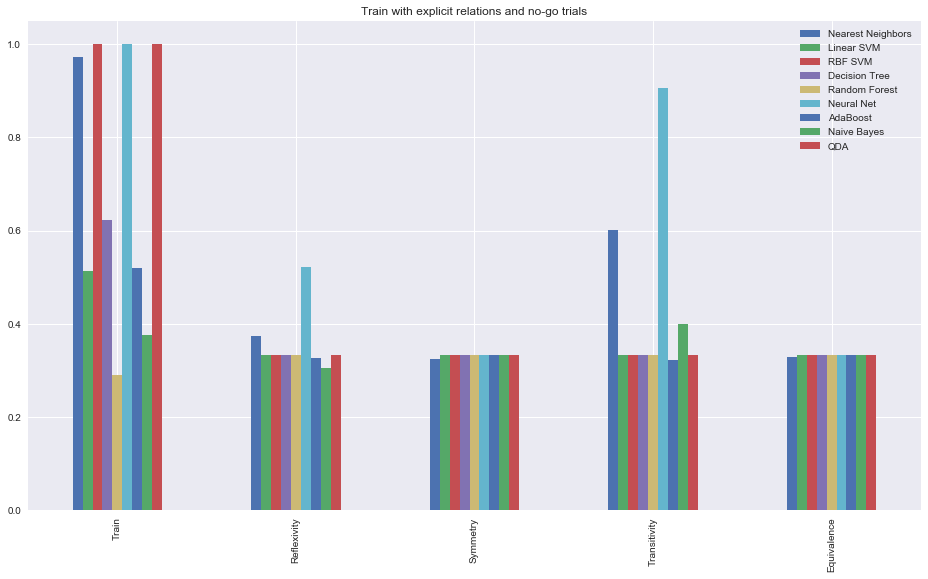

In [42]:
# results_df.T.plot(kind="bar", figsize=(16,9), title="Train only")
# results_df.T.plot(kind="bar", figsize=(16,9), title="Train with explicit relations")
# results_df.T.plot(kind="bar", figsize=(16,9), title="Train with no-go trials")
results_df.T.plot(kind="bar", figsize=(16,9), title="Train with explicit relations and no-go trials")